In [12]:
from pysheds.grid import Grid
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2
from PIL import Image
import os

In [2]:
def sketch_rivers(tiff_image):
    grid = Grid.from_raster(tiff_image, data_name='dem')
    depressions = grid.detect_depressions('dem')
    grid.fill_depressions(data='dem', out_name='flooded_dem')
    flats = grid.detect_flats('flooded_dem')
    grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')
    # Compute flow direction based on corrected DEM
    dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
    # Compute flow accumulation based on computed flow direction
    grid.accumulation(data='dir', out_name='acc', dirmap=dirmap)
    
    downsampled_rivers = np.log(grid.view('acc') + 1)
    upsampled_rivers = cv2.pyrUp(downsampled_rivers, dstsize=(512, 512))
    upsampled_rivers = (upsampled_rivers - np.amin(upsampled_rivers)) / (np.amax(upsampled_rivers) - np.amin(upsampled_rivers))
    upsampled_rivers = np.array(upsampled_rivers * 255, dtype=np.uint8)
    _, thresholded_river = cv2.threshold(upsampled_rivers, 127, 255, cv2.THRESH_BINARY)
    thresholded_river[thresholded_river == 255] = 1
    skeletonized_rivers = skeletonize(thresholded_river)
    rivers_sketch = Image.fromarray(skeletonized_rivers)
    rgb_rivers_sketch = rivers_sketch.convert('RGB')

    upsampled_depressions = cv2.pyrUp(np.array(depressions, dtype=np.uint8), dstsize=(512, 512))
    upsampled_depressions = (upsampled_depressions - np.amin(upsampled_depressions)) / (np.amax(upsampled_depressions) - np.amin(upsampled_depressions))
    upsampled_depressions = np.array(upsampled_depressions * 255, dtype=np.uint8)
    _, thresholded_depressions = cv2.threshold(upsampled_depressions, 127, 255, cv2.THRESH_BINARY)
    basins_sketch = Image.fromarray(thresholded_depressions)
    rgb_basins_sketch = basins_sketch.convert('RGB')
    
    return rgb_rivers_sketch, rgb_basins_sketch

In [3]:
def sketch_ridges(tiff_image):
    grid = Grid.from_raster(tiff_image, data_name='dem')
    grid.dem = grid.dem.max() - grid.dem
    peaks = grid.detect_depressions('dem')
    grid.fill_depressions(data='dem', out_name='flooded_dem')
    flats = grid.detect_flats('flooded_dem')
    grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')
    # Compute flow direction based on corrected DEM
    dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
    # Compute flow accumulation based on computed flow direction
    grid.accumulation(data='dir', out_name='acc', dirmap=dirmap)
    downsampled_ridges = np.log(grid.view('acc') + 1)
    
    upsampled_ridges = cv2.pyrUp(downsampled_ridges, dstsize=(512, 512))
    upsampled_ridges = (upsampled_ridges - np.amin(upsampled_ridges)) / (np.amax(upsampled_ridges) - np.amin(upsampled_ridges))
    upsampled_ridges = np.array(upsampled_ridges * 255, dtype=np.uint8)
    _, thresholded_ridges = cv2.threshold(upsampled_ridges, 150, 255, cv2.THRESH_BINARY)
    thresholded_ridges[thresholded_ridges == 255] = 1
    skeletonized_ridges = skeletonize(thresholded_ridges)
    ridges_sketch = Image.fromarray(skeletonized_ridges)
    rgb_ridges_sketch = ridges_sketch.convert('RGB')
    
    upsampled_peaks = cv2.pyrUp(np.array(peaks, dtype=np.uint8), dstsize=(512, 512))
    upsampled_peaks = (upsampled_peaks - np.amin(upsampled_peaks)) / (np.amax(upsampled_peaks) - np.amin(upsampled_peaks))
    upsampled_peaks = np.array(upsampled_peaks * 255, dtype=np.uint8)
    _, thresholded_peaks = cv2.threshold(upsampled_peaks, 127, 255, cv2.THRESH_BINARY)
    peaks_sketch = Image.fromarray(thresholded_peaks)
    rgb_peaks_sketch = peaks_sketch.convert('RGB')
    
    return rgb_ridges_sketch, rgb_peaks_sketch

In [4]:
def prepare_heightmap_sketch(file_path):
    rivers, basins = sketch_rivers(file_path)
    ridges, peaks = sketch_ridges(file_path)

    sketch = np.zeros([512,512,3],dtype=np.uint8)
    sketch.fill(255)

    pixels_rivers = rivers.load() # create the pixel map
    
    for i in range(rivers.size[0]): # for every pixel:
        for j in range(rivers.size[1]):
            if pixels_rivers[i,j] == (255, 255, 255):
                sketch[j,i] = (0, 0, 255)

            
    pixels_basins = basins.load() # create the pixel map
            
    for i in range(basins.size[0]): # for every pixel:
        for j in range(basins.size[1]):
            if pixels_basins[i,j] == (255, 255, 255):
                sketch[j,i] = (0, 255, 0)    
            
            
    pixels_ridges = ridges.load() # create the pixel map
            
    for i in range(ridges.size[0]): # for every pixel:
        for j in range(ridges.size[1]):
            if pixels_ridges[i,j] == (255, 255, 255):
                sketch[j,i] = (255, 0, 0) 
            
            
    pixels_peaks = peaks.load() # create the pixel map

    for i in range(peaks.size[0]): # for every pixel:
        for j in range(peaks.size[1]):
            if pixels_peaks[i,j] == (255, 255, 255):
                sketch[j,i] = (0, 0, 0)   
            
    sketch_image = Image.fromarray(sketch)
    
    return sketch_image

In [7]:
src_list, tar_list = list(), list()

iterator = 0
for filename in os.listdir('cut_tif_data'):
    if filename.endswith(".tif"): 
        iterator += 1
        print('Loop ' + str(iterator))
        sketch = prepare_heightmap_sketch('cut_tif_data/' + filename)
        heightmap = cv2.imread('cut_tif_data/' + filename)
        
        sketch_array = np.array(sketch)
        heightmap_array = np.array(heightmap)
        
        src_list.append(sketch_array)
        tar_list.append(heightmap_array)



np.savez_compressed('maps_256.npz', np.asarray(src_list), np.asarray(tar_list))

Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9
Loop 10
Loop 11
Loop 12
Loop 13
Loop 14


Loaded:  (14, 512, 512, 3) (14, 256, 256, 3)


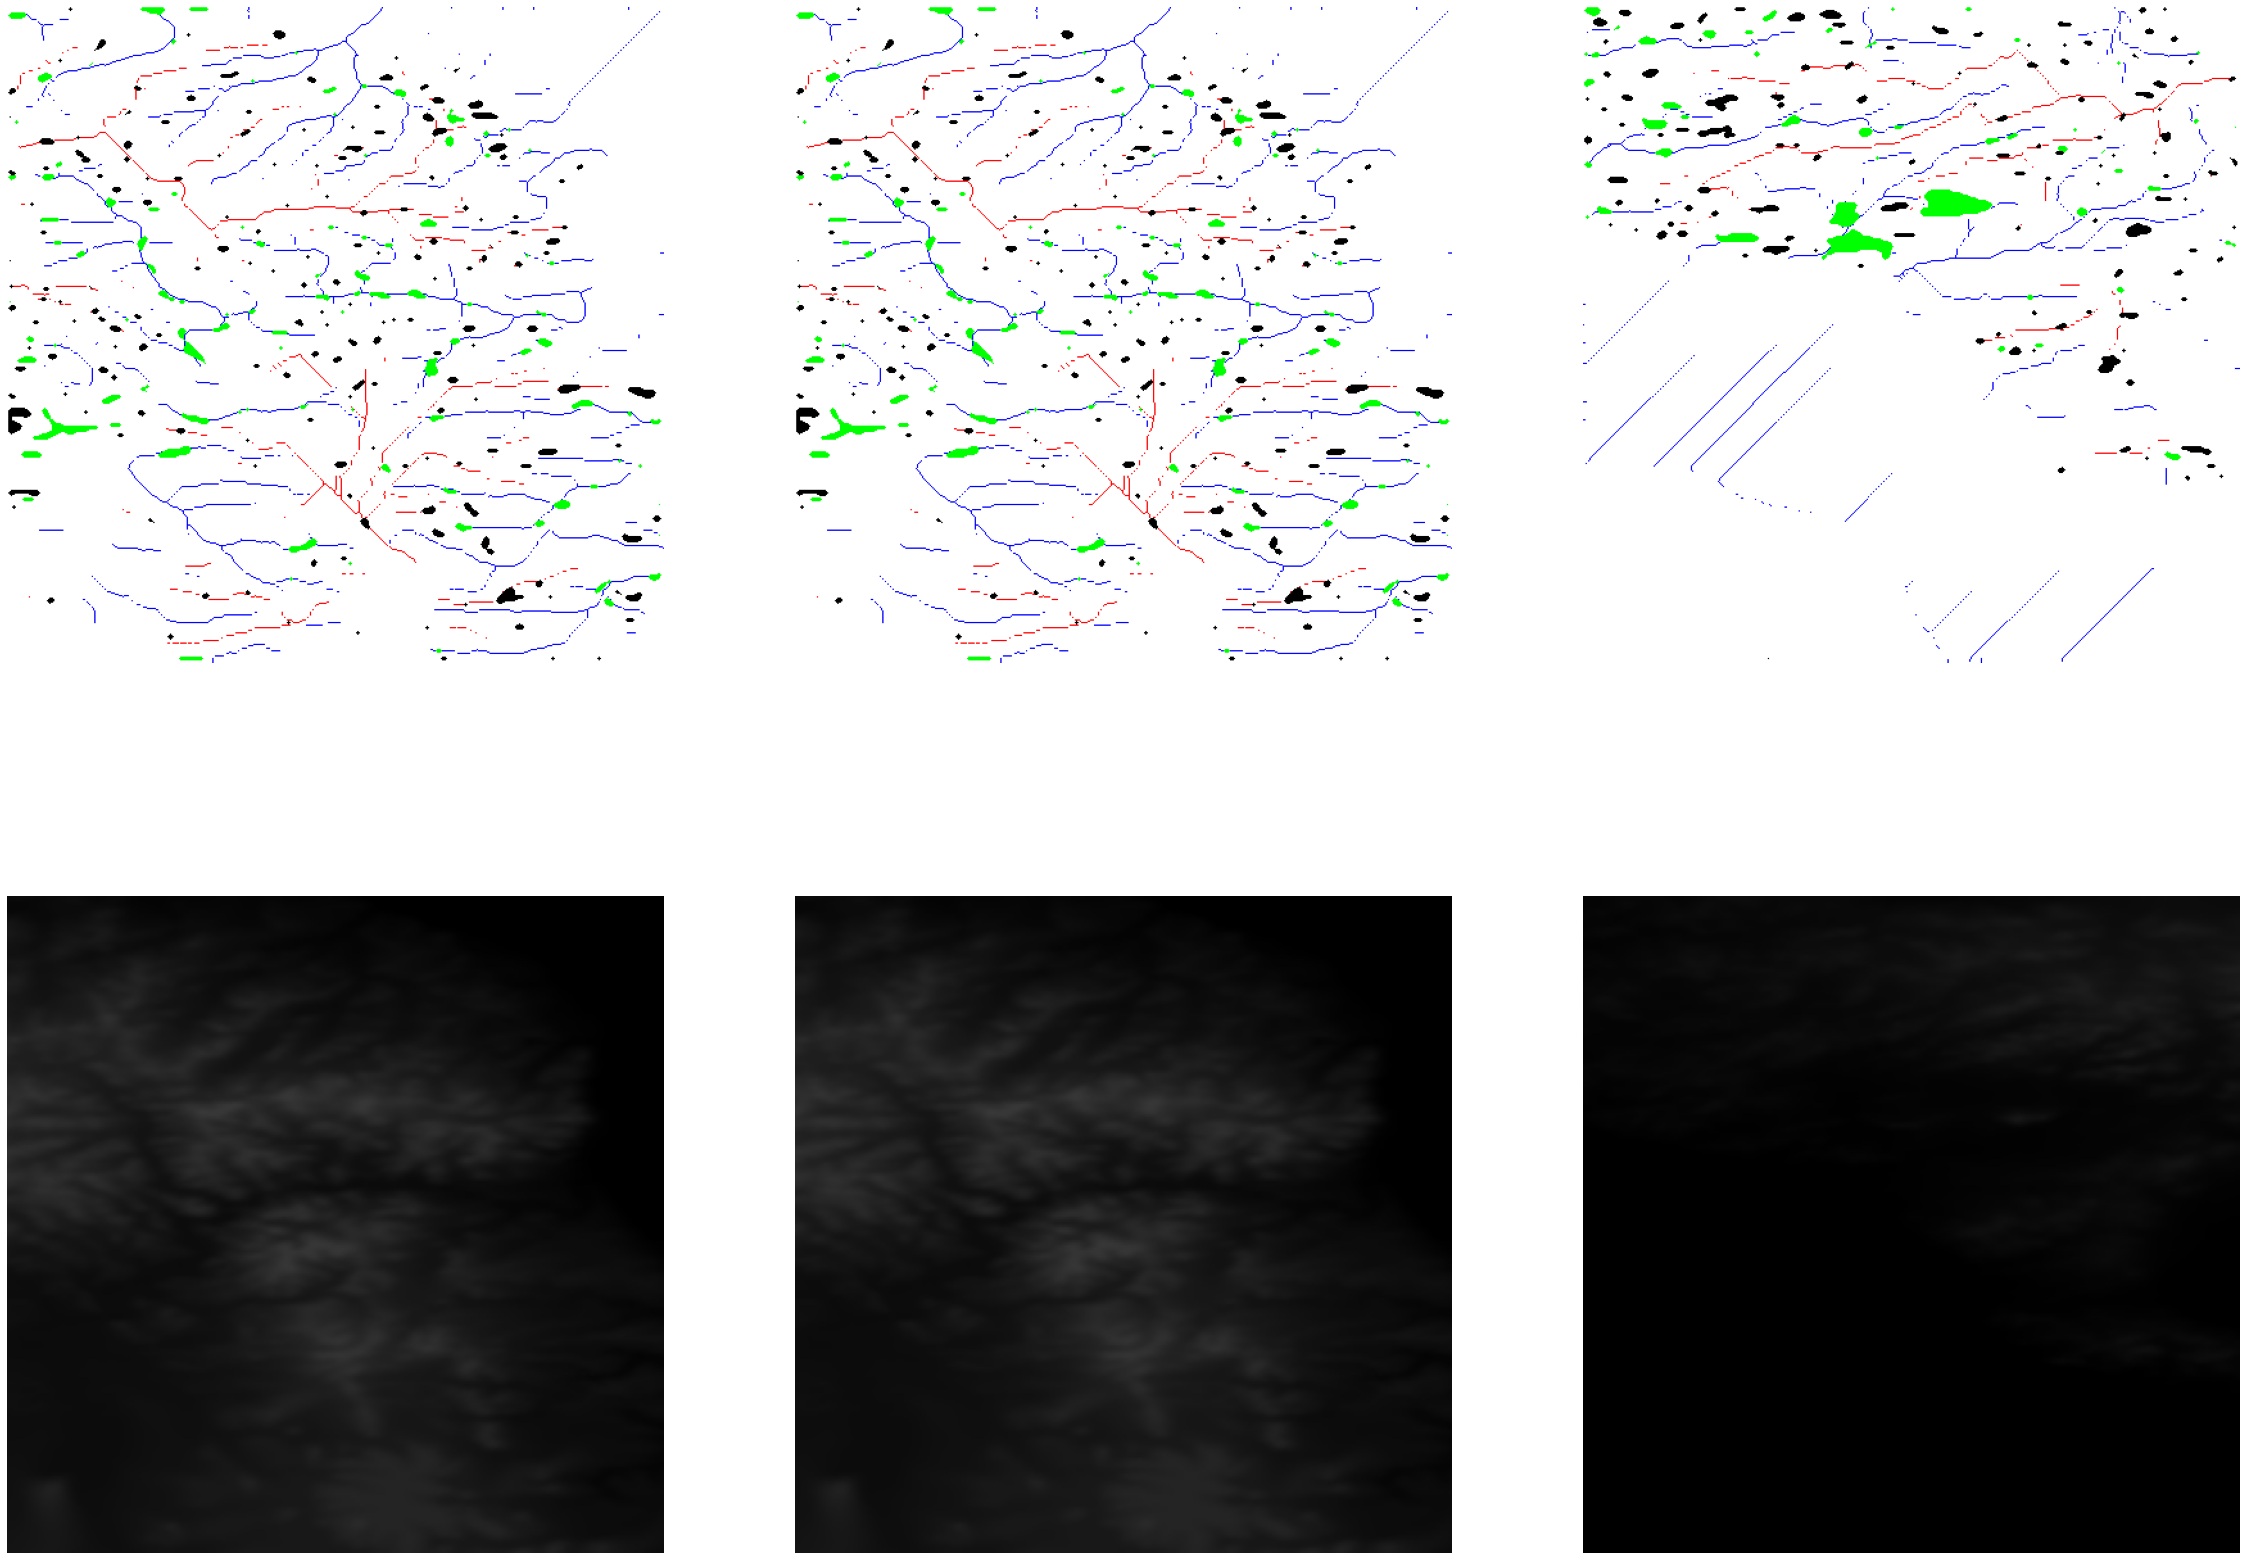

In [56]:
data = np.load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)

# plot source images
n_samples = 3

index = []
for i in range(n_samples):
    index.append(random.randint(0, len(src_images) - 1))

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_images[index[i]].astype('uint8'))
    
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(tar_images[index[i]].astype('uint8'))
    
plt.rcParams['figure.figsize'] = [40, 60]
plt.show()
